# Simple Row-Aggregating Features With Stacking In The Movielens Dataset 

This example illustrates using `pandas`-munging capabilities in estimators building features that draw from several rows. We will use a single table from the [Movielens dataset](https://grouplens.org/datasets/movielens/) (F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS)).

## Loading The Data

In this example, we'll only use the dataset table describing the ratings themselves. I.e., each row is an instance of a single rating given by a specific user to a specific movie.

In [37]:
from sklearn import datasets

print(datasets.load_boston()['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [1]:
import os

from sklearn import base
from scipy import stats
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.despine()

import ibex
from ibex.sklearn import model_selection as pd_model_selection
from ibex.sklearn import linear_model as pd_linear_model
from ibex.xgboost import XGBRegressor as PdXGBRegressor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ratings = pd.read_csv(
    '../movielens_data/ml-100k/u.data', 
    sep='\t', 
    header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'])
features = ['user_id', 'item_id']
ratings = ratings.sample(frac=1)
ratings[features + ['rating']].head()

,user_id,item_id,rating
37674,214,24,3
11925,14,202,3
11791,222,288,4
77670,637,282,3
9881,16,418,5


## dd 

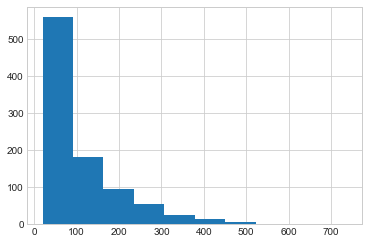

In [66]:
hist(ratings.user_id.groupby(ratings.user_id).count().values);

In [67]:
np.random.rand()

0.8667765537463517

In [74]:
np.random.choice([1, 2], p=[0.1, 0.9])

2

In [77]:
p = 0.1

def sample_group(g):
    frac = np.random.choice([1. / len(g), 2. / len(g), 2. / len(g), 1], p=[0.2, 0.2, 0.2, 0.4])
    return g.sample(frac=frac)


reduced_ratings = ratings.groupby(ratings.user_id, as_index=False).apply(sample_group)
reduced_ratings.index = reduced_ratings.index.levels[1]
reduced_ratings = reduced_ratings.sample(frac=1)
reduced_ratings.head()

,user_id,item_id,rating,timestamp
26615,263,432,2,891299448
90232,851,92,5,875806791
76601,682,180,3,888516979
38756,339,241,4,891034152
19937,190,898,2,891033349


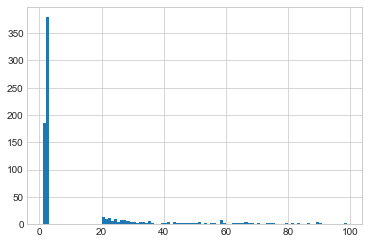

In [79]:
hist(reduced_ratings.user_id.groupby(reduced_ratings.user_id).count().values, bins=range(1, 100));

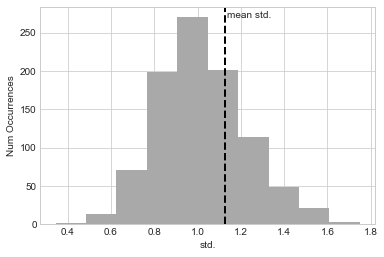

In [80]:
by_user_std = ratings.rating.groupby(ratings.user_id).std()
axvline(
    ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * ratings.rating.std(), int(max(hist(by_user_std)[0]))));
hist(
    by_user_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')

## Stacking Using Pandas

Unsuprisingly, the results are even worse than before. Methodically, this is the correct way of building the feature without peeking, and so the CV result should intuitively be weaker.

In [12]:
user_ratings[user_ratings.user_id == 1]

NameError: name 'user_ratings' is not defined

## Building A Pandas-Munging Stacking Estimator

We'll now use Pandas to build a feature building these features. 

* For each movie, we'll store the mean score & number of occurrences.

* For each user, we'll store the mean score & number of occurrences.

In [4]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.groupby(X.user_id).mean().mean()
        self._user_id_stats = y.groupby(X.user_id).agg([np.mean, 'count'])
        self._user_id_stats.columns = ['user_id_mean', 'user_id_count']
        return self
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        return user_ratings
    
f = ScoresAggregator()
f.fit_transform(ratings[features], ratings.rating);

In [5]:
f = ScoresAggregator()

In [6]:
f.fit_transform(ratings[features], ratings.rating);

0.16074587848917044

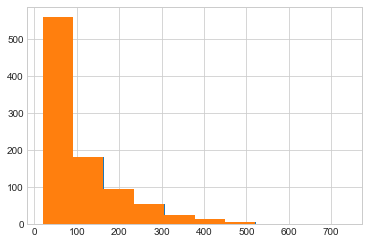

In [20]:
class StackingScoresAggregator(ScoresAggregator):
    def fit_transform(self, X, y):
        user_rating_stats = \
            y.groupby(X.user_id).agg([np.sum, 'count'])    
        user_rating_stats.columns = ['user_id_sum', 'user_id_count']
        hist(user_rating_stats['user_id_count'])
        
        X_ = pd.concat([X['user_id'], y], axis=1)
        X_.columns = ['user_id', 'rating']
        user_ratings = pd.merge(
            X_,
            user_rating_stats,
            left_on='user_id',
            right_index=True,
            how='left')
        user_ratings.user_id_count -= 1
        user_ratings['user_id_mean'] = np.where(
            user_ratings.user_id_count == 0,
            y.groupby(X.user_id).mean().mean(), # Tmp Ami
            (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)
        
        self.fit(X, y)
        
        hist(user_ratings['user_id_count'].groupby(user_ratings['user_id']).min());
        
        # return self.fit(X, y).transform(X)
        return user_ratings[['user_id_mean', 'user_id_count']]
    
from ibex.sklearn.linear_model import LinearRegression as PdLinearRegression
from ibex.sklearn.preprocessing import PolynomialFeatures as PdPolynomialFeatures
prd = ScoresAggregator() | PdPolynomialFeatures(degree=2) | PdLinearRegression()
stacking_prd = StackingScoresAggregator() | PdPolynomialFeatures(degree=2) | PdLinearRegression()
stacking_prd.fit(ratings[features], ratings.rating).score(ratings[features], ratings.rating)
#stacking_prd.steps[1][1].feature_importances_

In [21]:
scores = pd_model_selection.cross_val_score(prd, ratings[features], ratings.rating, cv=100, n_jobs=1)

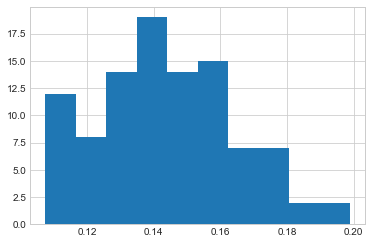

In [22]:
hist(scores);

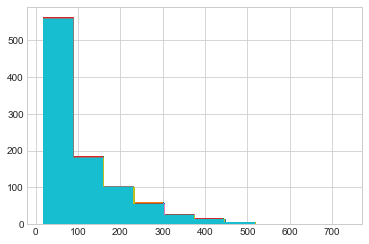

In [23]:
stacking_scores = pd_model_selection.cross_val_score(stacking_prd, ratings[features], ratings.rating, cv=100, n_jobs=1)

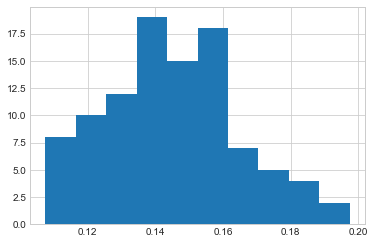

In [24]:
hist(stacking_scores);

In [ ]:
plot(scores, stacking_scores, '+');
plot(np.linspace(0, 0.25, 100), np.linspace(0, 0.25, 100))

In [ ]:
PdPolynomialFeatures?

In [ ]:
hist(stacking_scores - scores);

In [ ]:
np.mean(stacking_scores - scores)

In [ ]:
stacking_scores == scores

In [ ]:
from scipy import stats

In [ ]:
stats.mannwhitneyu(stacking_scores, scores, alternative='less')

In [ ]:
stacking_prd.steps[1][1].feature_importances_

In [ ]:
prd

In [ ]:
prd.steps[1][1]

In [ ]:
preprocessing.PolynomialFeatures?

In [ ]:
from sklearn import preprocessing

In [ ]:
preprocessing.PolynomialFeatures().fit_transform(ratings[features]).shape

In [ ]:
ratings[features].shape

In [ ]:
from ibex.sklearn import preprocessing as pd_preprocessing

In [ ]:
pd_preprocessing.PolynomialFeatures().fit_transform(ratings[features])